# Step-by-step demonstration

## Lib Imports and configurations

In [1]:
# %matplotlib notebook
# %matplotlib inline 
%load_ext autoreload
%autoreload 2

import sys
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
from ruptures.metrics import precision_recall, meantime
import scipy.stats as ss
from itertools import islice

sys.path.append("Codes/")
import TMPD_utils
import TMPD_class

import warnings
warnings.filterwarnings("ignore")

import gc
gc.enable()

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 150)
# pd.set_option('display.float_format', lambda x: f'{x:,.3f}')
pd.options.display.float_format = '{:.4f}'.format


## Loading event log

In [2]:
# Mapping all event_logs paths
logs_path = glob.glob("Input/Synthetic/Business Process Drift (Maaradji - Fast)/logs/*/*k.*")

# Removing the logs with 2500 and 5000 events (based on Maaradji paper)
# logs_path = [x for x in logs_path if "10" in x or "7.5" in x]
change_patterns_excluded = ['IOR', 'IRO', 'OIR', 'ORI', 'RIO', 'ROI']
logs_path = [x for x in logs_path if "10" in x and not any(keyword in x for keyword in change_patterns_excluded)] 

# Showing mapped paths
print("How many logs? ", len(logs_path))
pd.DataFrame(logs_path)

How many logs?  12


,0
0,Input/Synthetic/Business Process Drift (Maaradji - Fast)/logs\cb\cb10k.mxml
1,Input/Synthetic/Business Process Drift (Maaradji - Fast)/logs\cd\cd10k.mxml
2,Input/Synthetic/Business Process Drift (Maaradji - Fast)/logs\cf\cf10k.mxml
3,Input/Synthetic/Business Process Drift (Maaradji - Fast)/logs\cm\cm10k.mxml
4,Input/Synthetic/Business Process Drift (Maaradji - Fast)/logs\cp\cp10k.mxml
5,Input/Synthetic/Business Process Drift (Maaradji - Fast)/logs\fr\fr10k.MXML
6,Input/Synthetic/Business Process Drift (Maaradji - Fast)/logs\lp\lp10k.mxml
7,Input/Synthetic/Business Process Drift (Maaradji - Fast)/logs\pl\pl10k.mxml
8,Input/Synthetic/Business Process Drift (Maaradji - Fast)/logs\pm\pm10k.mxml
9,Input/Synthetic/Business Process Drift (Maaradji - Fast)/logs\re\re10k.mxml


<!-- ![Alt text](../Images/Concept_drift_firstcycle_steps_eng.png "General steps") -->

In [3]:
# Loading first event log
log_path = logs_path[1]
print(log_path.split("\\")[-1].split(".")[0])
event_log = TMPD_utils.parse_mxml(log_path)

# This is a specifc step for this event log that separates in different rows the start and end of an activity. As we will only use one timestamp, we are filtering only the row representing the end of an activity.  
event_log = event_log[event_log.EventType == "complete"]

# Save original event index
event_log = event_log.reset_index(names='original_index') 

# Create an id based on the order of the event in the raw event log
event_log["Event_order_id"] = event_log.index

# This is a specifc step for this event log, because it have duplicated case ids. So we create a new case id.
event_log["Trace_order"] = TMPD_utils.cumulative_counting(event_log["CaseId"])

# # Add a Start and End activities case it doesn't have
# event_log = TMPD_utils.add_start_end_activities(event_log=event_log, case_id_col="Trace_order", activity_col="Activity", timestamp_col="Timestamp")

# Showing loaded event log
print("Total events: ", len(event_log))
print("Total cases: ", len(event_log.groupby('CaseId')))
print("Total activities: ", len(event_log.groupby('Activity')))
event_log.head(15)

cd10k
Total events:  103218
Total cases:  10000
Total activities:  19


,original_index,CaseId,WorkflowModelElement,EventType,Timestamp,Originator,Activity,Event_order_id,Trace_order
0,1,b1_503,Loan__application_received,complete,2004-03-16T12:30:00.000+00:00,NaN,Loan__application_received,0,0
1,3,b1_503,Check__application__form_completeness,complete,2004-03-16T12:38:33.151+00:00,NaN,Check__application__form_completeness,1,0
2,6,b1_503,Appraise_property,complete,2004-03-16T12:48:29.200+00:00,NaN,Appraise_property,2,0
3,7,b1_503,Check_credit_history,complete,2004-03-16T12:53:00.728+00:00,NaN,Check_credit_history,3,0
4,9,b1_503,Assess_loan_risk,complete,2004-03-16T14:02:18.419+00:00,NaN,Assess_loan_risk,4,0
5,11,b1_503,Assess_eligibility,complete,2004-03-16T14:36:07.005+00:00,NaN,Assess_eligibility,5,0
6,13,b1_503,Reject_application,complete,2004-03-16T15:21:24.281+00:00,NaN,Reject_application,6,0
7,15,b1_503,Loan_application_rejected,complete,2004-03-16T15:21:24.281+00:00,NaN,Loan_application_rejected,7,0
8,17,b1_501,Loan__application_received,complete,2004-03-16T11:30:00.000+00:00,NaN,Loan__application_received,8,1
9,19,b1_501,Check__application__form_completeness,complete,2004-03-16T11:33:07.015+00:00,NaN,Check__application__form_completeness,9,1


## Step 1 - Instantiating class and setting event log

In [4]:
# Iniatializing the TMPD_class
TMPD_instance = TMPD_class.TMPD(scenario='offline')

# Setting the transition log
TMPD_instance.set_transition_log(event_log, case_id='Trace_order', activity_key='Activity', timestamp_key='Timestamp', timestamp_format=None, other_columns_keys=[])

# Executing the transition log
TMPD_instance.run_transition_log()

# Showing the transition log created
print(len(TMPD_instance.get_transition_log()))
TMPD_instance.get_transition_log().head(20)

113218


,original_index,case_id,activity_from,timestamp_from,activity_to,timestamp_to,transition_id,case_order
0,103218,0,START,2004-03-16T12:30:00.000+00:00,Loan__application_received,2004-03-16T12:30:00.000+00:00,0,0
1,0,0,Loan__application_received,2004-03-16T12:30:00.000+00:00,Check__application__form_completeness,2004-03-16T12:38:33.151+00:00,1,1
2,1,0,Check__application__form_completeness,2004-03-16T12:38:33.151+00:00,Appraise_property,2004-03-16T12:48:29.200+00:00,2,2
3,2,0,Appraise_property,2004-03-16T12:48:29.200+00:00,Check_credit_history,2004-03-16T12:53:00.728+00:00,3,3
4,3,0,Check_credit_history,2004-03-16T12:53:00.728+00:00,Assess_loan_risk,2004-03-16T14:02:18.419+00:00,4,4
5,4,0,Assess_loan_risk,2004-03-16T14:02:18.419+00:00,Assess_eligibility,2004-03-16T14:36:07.005+00:00,5,5
6,5,0,Assess_eligibility,2004-03-16T14:36:07.005+00:00,Reject_application,2004-03-16T15:21:24.281+00:00,6,6
7,6,0,Reject_application,2004-03-16T15:21:24.281+00:00,Loan_application_rejected,2004-03-16T15:21:24.281+00:00,7,7
8,7,0,Loan_application_rejected,2004-03-16T15:21:24.281+00:00,END,2004-03-16T15:21:24.281+00:00,8,8
9,103219,1,START,2004-03-16T11:30:00.000+00:00,Loan__application_received,2004-03-16T11:30:00.000+00:00,9,0


## Step 2 - Setting Window Strategy

In [5]:
# Setting the window strategy parameters
TMPD_instance.set_windowing_strategy(window_size_mode = 'Fixed', window_size = 4000, window_ref_mode = 'Fixed', overlap = True, sliding_step = 200, continuous = True)

# Executing the window strategy indexation
TMPD_instance.run_windowing_strategy()

# Showing the windows indexes
dict(list(TMPD_instance.get_windowing_strategy().items()))

{0: {'start': 0, 'end': 4000, 'window_index': 0},
 1: {'start': 200, 'end': 4200, 'window_index': 1},
 2: {'start': 400, 'end': 4400, 'window_index': 2},
 3: {'start': 600, 'end': 4600, 'window_index': 3},
 4: {'start': 800, 'end': 4800, 'window_index': 4},
 5: {'start': 1000, 'end': 5000, 'window_index': 5},
 6: {'start': 1200, 'end': 5200, 'window_index': 6},
 7: {'start': 1400, 'end': 5400, 'window_index': 7},
 8: {'start': 1600, 'end': 5600, 'window_index': 8},
 9: {'start': 1800, 'end': 5800, 'window_index': 9},
 10: {'start': 2000, 'end': 6000, 'window_index': 10},
 11: {'start': 2200, 'end': 6200, 'window_index': 11},
 12: {'start': 2400, 'end': 6400, 'window_index': 12},
 13: {'start': 2600, 'end': 6600, 'window_index': 13},
 14: {'start': 2800, 'end': 6800, 'window_index': 14},
 15: {'start': 3000, 'end': 7000, 'window_index': 15},
 16: {'start': 3200, 'end': 7200, 'window_index': 16},
 17: {'start': 3400, 'end': 7400, 'window_index': 17},
 18: {'start': 3600, 'end': 7600, 'wi

## Step 3 - Setting Process Representation (using Transition Matrix)

In [6]:
# Setting the Transition Matrix (TM) process representation
TMPD_instance.set_process_representation(threshold_anomaly=0.005
                                    , control_flow_features={'frequency', 'probability'}
                                    , time_features={} #{'avg_time':'timestamp', 'time_std':'timestamp'}
                                    , resource_features={}
                                    , data_features={})

# Executing the process_representation using all dataset just for an example
TMPD_instance.run_process_representation(TMPD_instance.transition_log)

# Showing the process representation created
TMPD_instance.get_process_representation()#.head(15)

frequency  \
activity_from                              activity_to                                             
Appraise_property                          Assess_eligibility                               1221   
                                           Assess_loan_risk                                 3814   
                                           Check_credit_history                             4965   
Approve_application                        Loan__application_approved                       2513   
Assess_eligibility                         Prepare_acceptance_pack                          5026   
                                           Reject_application                               4974   
Assess_loan_risk                           Appraise_property                                1221   
                                           Assess_eligibility                               8779   
Cancel_application                         Loan__application_canceled                       2513   
Check__application__form_completeness      Appraise_property                                4965   
                                           Check_credit_history                             5035   
                                           Return_application_back_to_applicant             1038   
Check_credit_history                       Appraise_property                                3814   
                                           Assess_loan_risk                                 6186   
Check_if_home_insurance_quote_is_requested Send_acceptance_pack                             2553   
                                           Send_home_insurance_quote                        2473   
Loan__application_approved                 END                                              2513   
Loan__application_canceled                 END                                              2513   
Loan__application_received                 Check__application__form_completeness           10000   
Loan_application_rejected                  END                                              4974   
Prepare_acceptance_pack                    Check_if_home_insurance_quote_is_requested       5026   
Receive_updated_application                Check__application__form_completeness            1038   
Reject_application                         Loan_application_rejected                        4974   
Return_application_back_to_applicant       Receive_updated_application                      1038   
START                                      Loan__application_received                      10000   
Send_acceptance_pack                       Verify_repayment_agreement                       2553   
Send_home_insurance_quote                  Verify_repayment_agreement                       2473   
Verify_repayment_agreement                 Approve_application                              2513   
                                           Cancel_application                               2513   

                                                                                       probability  
activity_from                              activity_to                                              
Appraise_property                          Assess_eligibility                               0.1221  
                                           Assess_loan_risk                                 0.3814  
                                           Check_credit_history                             0.4965  
Approve_application                        Loan__application_approved                       1.0000  
Assess_eligibility                         Prepare_acceptance_pack                          0.5026  
                                           Reject_application                               0.4974  
Assess_loan_risk                           Appraise_property                                0.1221  
                                           Assess_eligibility                

## Step 4 - Setting Change Representation

In [7]:
# Defining the change features
change_features_strategy_dict = {
    'delta_matrix_strategy': 
        {
            'frequency_delta' : {'process_feature':'frequency', 'method':'aggregation', 'agg_function' : 'sum'}
            , 'probability_delta' : {'process_feature':'probability', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'causality_delta' : {'process_feature':'causality', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'parallel_delta' : {'process_feature':'parallel', 'method':'aggregation', 'agg_function' : 'sum'}
            , 'frequency_delta_percentage' : {'process_feature':'frequency', 'method':'percentage'}
            , 'prob_freq_delta_weight' : {'process_feature':'probability', 'method':'aggregation_weight', 'agg_function' : 'sum', 'weight_feature' : 'frequency'}
            # , 'avg_time_delta' : {'process_feature':'avg_time', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'time_std_delta' : {'process_feature':'time_std', 'method':'aggregation', 'agg_function' : 'sum'}
        }
    , 'statistic_test_strategy' : 
        {
            'frequency_gtest_pvalue' : {'process_feature':'frequency', 'method':'g_test', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
            , 'frequency_cramersv' : {'process_feature':'frequency', 'method':'cramers_v', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
        }
    }

# Setting Change Representation
TMPD_instance.set_change_representation(change_features_strategy_dict)

# Executing the Change Representation using the window strategy
TMPD_instance.run_change_representation()

# Showing the Change Representation created
TMPD_instance.get_change_representation().head(15)

,start,end,window_index,reference_window_index,frequency_delta,probability_delta,frequency_delta_percentage,prob_freq_delta_weight,frequency_gtest_pvalue,frequency_cramersv
0,0,4000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,200,4200,1,0,56.0000,0.0892,0.0070,0.2359,1.0000,0.0000
2,400,4400,2,0,58.0000,0.1184,0.0073,0.3640,1.0000,0.0000
3,600,4600,3,0,78.0000,0.1554,0.0097,0.5197,1.0000,0.0000
4,800,4800,4,0,76.0000,0.1649,0.0095,0.6272,1.0000,0.0000
5,1000,5000,5,0,128.0000,0.2505,0.0160,1.3209,1.0000,0.0000
6,1200,5200,6,0,130.0000,0.2059,0.0163,1.3762,1.0000,0.0000
7,1400,5400,7,0,202.0000,0.2437,0.0253,2.3286,1.0000,0.0000
8,1600,5600,8,0,148.0000,0.2277,0.0185,1.4464,1.0000,0.0000
9,1800,5800,9,0,120.0000,0.1931,0.0150,1.0458,1.0000,0.0000


## Step 5 - Setting Detection Task

In [8]:
# Defining detection strategies
detection_task_strategy_dict = {
    'time_series_strategy': 
    {
        'cpd_frequency_delta' : {'change_features':['frequency_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        , 'cpd_prob_freq_delta' : {'change_features':['prob_freq_delta_weight'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_prob_causality_delta' : {'change_features':['causality_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_prob_parallel_delta' : {'change_features':['parallel_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_avg_time_delta' : {'change_features':['avg_time_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_time_std_delta' : {'change_features':['time_std_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        , 'cramersv_frequency' : {'change_features':['frequency_cramersv'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
    }
    , 'threshold_strategy' : 
    {
        'gtest_frequency' : {'change_features':['frequency_gtest_pvalue'], 'method':'comparison_operator', 'operator' : 'le', 'threshold_value' : '0.025', 'smooth' : '3'}
        , 'cramersv_frequency' : {'change_features':['frequency_cramersv'], 'method':'comparison_operator', 'operator' : 'ge', 'threshold_value' : '0.05', 'smooth' : '3'}
        # , 'fixed_frequency_delta_percentage' : {'change_features':['frequency_delta_percentage'], 'method':'comparison_operator', 'operator' : 'ge', 'threshold_value' : '0.05', 'smooth' : '3'}
    }
}

# Setting Detection Task
TMPD_instance.set_detection_task(detection_task_strategy_dict)

# Executing the Detection Task
TMPD_instance.run_detection_task()

# Showing Detection Task Results
TMPD_instance.get_detection_task()


,detection_strategy,detection_feature,detection_results
0,time_series_strategy,cpd_frequency_delta,"[31, 52, 103, 165, 213, 272, 333, 386, 443, 503, 547]"
1,time_series_strategy,cpd_prob_freq_delta,"[52, 102, 165, 212, 278, 326, 391, 441, 504, 547]"
2,time_series_strategy,cramersv_frequency,"[49, 104, 164, 213, 275, 327, 389, 442, 503, 547]"
3,threshold_strategy,cramersv_frequency,"[45, 106, 157, 219, 268, 332, 383, 445, 497, 547]"
4,threshold_strategy,gtest_frequency,"[45, 106, 156, 219, 268, 333, 383, 445, 497, 547]"


In [9]:
### Grounding truth
log_size = event_log['Trace_order'].nunique()
ground_truth_traces_indexes = list(range(int(log_size/10), log_size, int(log_size/10)))

transition_log = TMPD_instance.get_transition_log()
ground_truth_events_indexes = transition_log[transition_log['case_id'].isin(ground_truth_traces_indexes)].groupby('case_id').first()['transition_id'].to_list()

# signals_indexes = signals.reset_index()
signals = TMPD_instance.get_change_representation()
ground_truth = []
for ground_truth_events_index in ground_truth_events_indexes:
    ground_truth.extend(signals[(signals['start'] <= ground_truth_events_index) 
                & (signals['end'] >= ground_truth_events_index)].head(1).index.to_list())
ground_truth = ground_truth + [len(signals)]
print("ground_truth: ", ground_truth)

ground_truth:  [37, 94, 150, 207, 264, 320, 376, 433, 490, 547]


In [10]:
### Validation metrics
margin_error_defined=3
detection_task_results = TMPD_instance.get_detection_task()
for index, row in detection_task_results.iterrows():
    try:
        detection_task_results.loc[index, 'ground_truth'] = str(ground_truth)

        # smooth = int(detection_task_strategy_dict[row['detection_strategy']][row['detection_feature']]['smooth'])

        # Margin of error give more margin to overlap if used.
        margin_error = int(margin_error_defined + 1)  if TMPD_instance.overlap == False else int(margin_error_defined + 1 + TMPD_instance.window_size/TMPD_instance.sliding_step)

        precision, recall = precision_recall(ground_truth, row['detection_results'], margin=margin_error)

        f1 = round(ss.hmean([precision, recall]),2)
        detection_task_results.loc[index, 'f1'] = f1
        
        delay = round(meantime(ground_truth, row['detection_results']), 2)
        detection_task_results.loc[index, 'delay'] = delay

    except Exception as e:
        print("Error:", e)
        detection_task_results.loc[index, 'ground_truth'] = str(ground_truth)
        detection_task_results.loc[index, 'f1'] = np.nan
        detection_task_results.loc[index, 'delay'] = np.nan
    
detection_task_results

,detection_strategy,detection_feature,detection_results,ground_truth,f1,delay
0,time_series_strategy,cpd_frequency_delta,"[31, 52, 103, 165, 213, 272, 333, 386, 443, 503, 547]","[37, 94, 150, 207, 264, 320, 376, 433, 490, 547]",0.9500,10.5000
1,time_series_strategy,cpd_prob_freq_delta,"[52, 102, 165, 212, 278, 326, 391, 441, 504, 547]","[37, 94, 150, 207, 264, 320, 376, 433, 490, 547]",1.0000,11.1100
2,time_series_strategy,cramersv_frequency,"[49, 104, 164, 213, 275, 327, 389, 442, 503, 547]","[37, 94, 150, 207, 264, 320, 376, 433, 490, 547]",1.0000,10.5600
3,threshold_strategy,cramersv_frequency,"[45, 106, 157, 219, 268, 332, 383, 445, 497, 547]","[37, 94, 150, 207, 264, 320, 376, 433, 490, 547]",1.0000,9.0000
4,threshold_strategy,gtest_frequency,"[45, 106, 156, 219, 268, 333, 383, 445, 497, 547]","[37, 94, 150, 207, 264, 320, 376, 433, 490, 547]",1.0000,9.0000


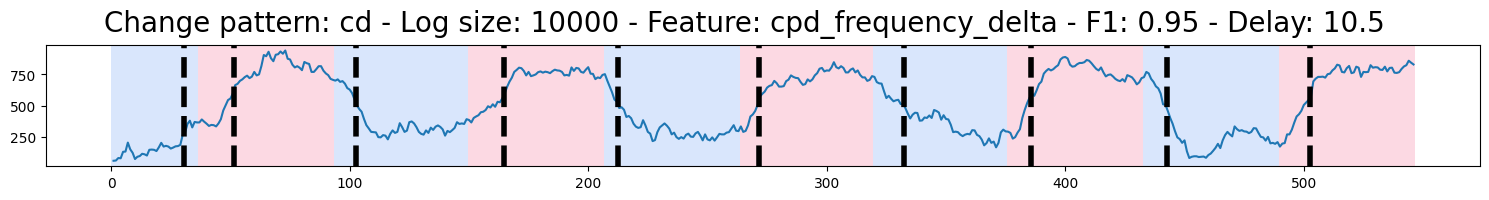

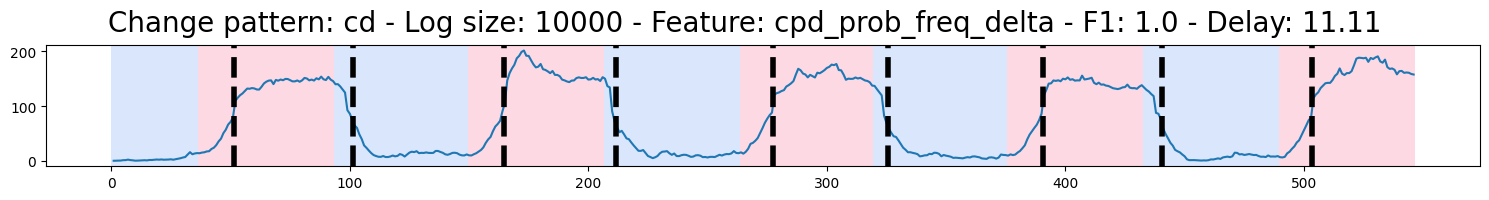

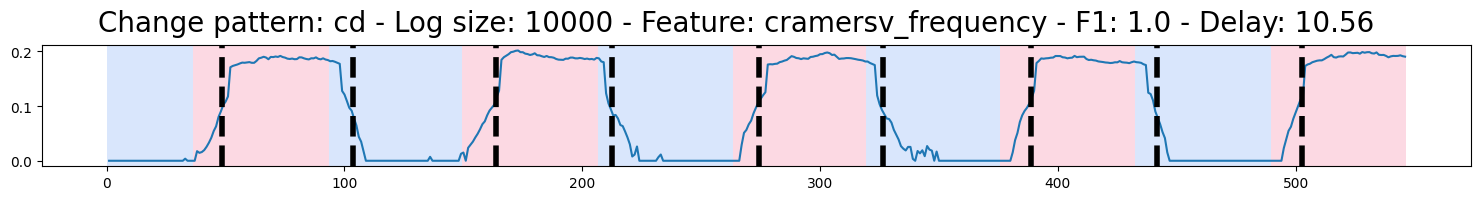

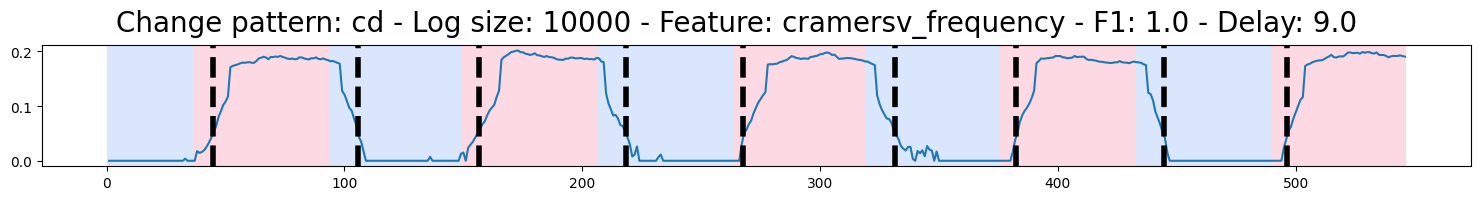

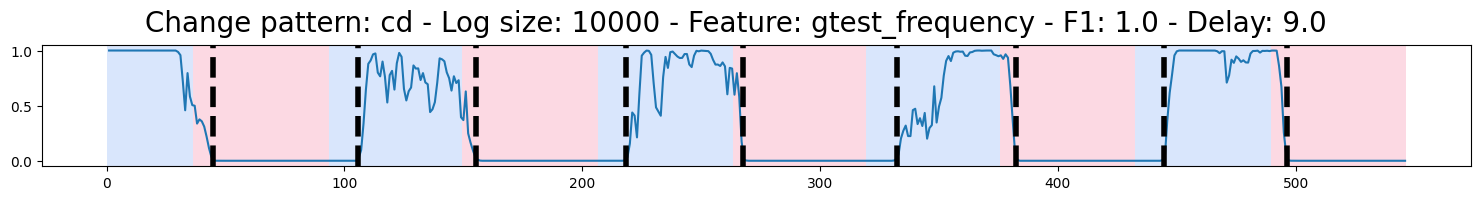

In [11]:
### Display Detection Task Results 

for result in detection_task_results.itertuples():
    fig, axarr = rpt.display(signal = TMPD_instance.get_change_representation()[TMPD_instance.detection_task_strategy_dict[result.detection_strategy][result.detection_feature]['change_features']]
                , true_chg_pts=ground_truth
                , computed_chg_pts = result.detection_results
                , computed_chg_pts_color = "k"
                , computed_chg_pts_linewidth = 4
                , computed_chg_pts_linestyle = "--"
                , computed_chg_pts_alpha = 1
                , figsize=(15, 2)
                )
    plt.suptitle("Change pattern: " + log_path.split("\\")[-2] 
                 + " - Log size: " + str(log_size)
                 + " - Feature: " + result.detection_feature
                 + " - F1: " + str(result.f1) 
                 + " - Delay: " + str(result.delay)
                 , fontsize=20)
    plt.subplots_adjust(top=0.8)
    plt.show()

## Step 6a - Setting Localization Task

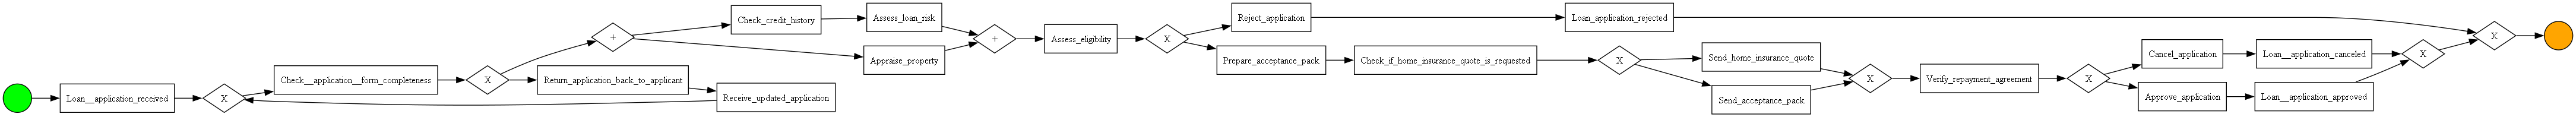

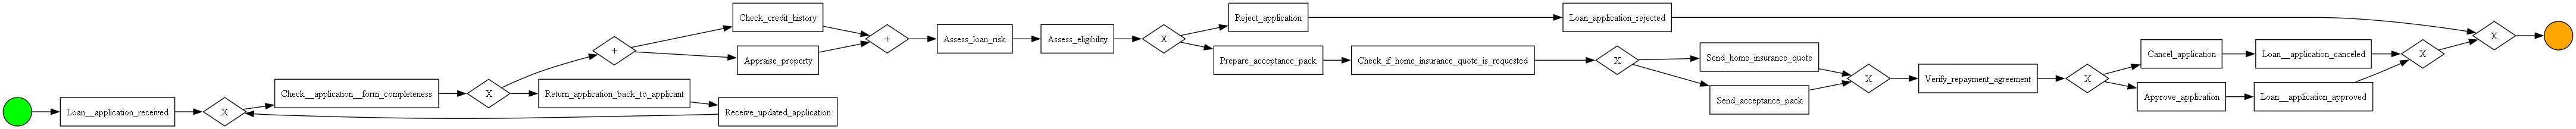

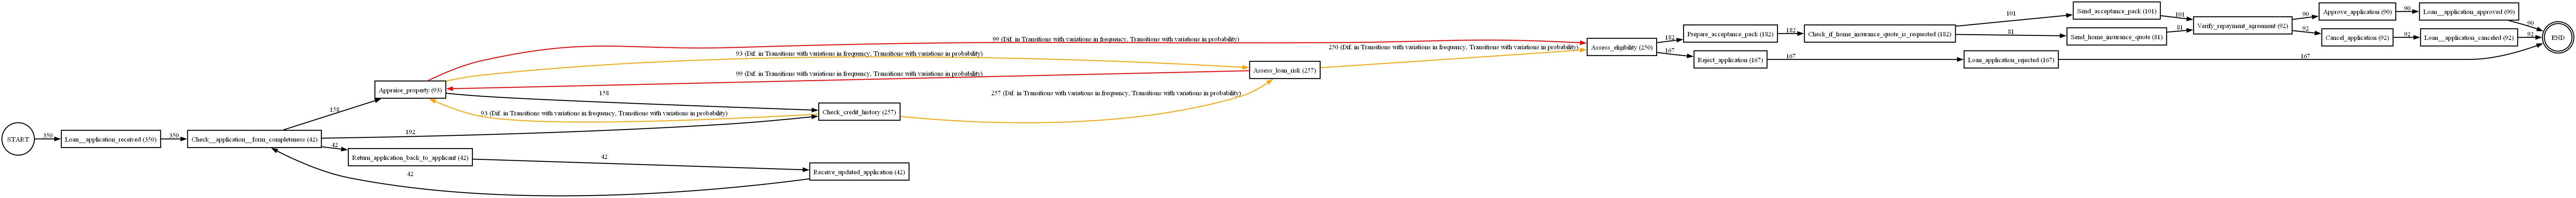

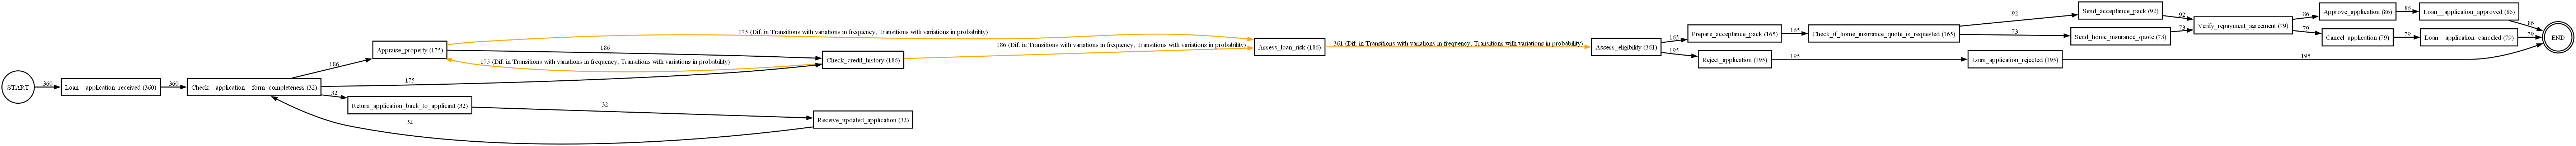

(                                   transition      feature  p_value  \
 0     (Appraise_property, Assess_eligibility)    frequency   0.0000   
 1     (Appraise_property, Assess_eligibility)  probability   0.0000   
 2       (Appraise_property, Assess_loan_risk)    frequency   0.0000   
 3       (Appraise_property, Assess_loan_risk)  probability   0.0000   
 4       (Assess_loan_risk, Appraise_property)    frequency   0.0000   
 5       (Assess_loan_risk, Appraise_property)  probability   0.0000   
 6      (Assess_loan_risk, Assess_eligibility)    frequency   0.0000   
 7      (Assess_loan_risk, Assess_eligibility)  probability   0.0000   
 8   (Check_credit_history, Appraise_property)    frequency   0.0000   
 9   (Check_credit_history, Appraise_property)  probability   0.0000   
 10   (Check_credit_history, Assess_loan_risk)    frequency   0.0006   
 11   (Check_credit_history, Assess_loan_risk)  probability   0.0000   
 
     effect_size  ref_value  det_value  dif_value  
 0        

In [12]:
# Setting Localization Task
TMPD_instance.set_localization_task(reference_window_index=0, detection_window_index=75, pvalue_threshold=0.05, effect_prop_threshold=0.2, effect_count_threshold=0.02, pseudo_count=5)

# Executing Localization Task
TMPD_instance.run_localization_task()

# Showing Localization Task Results
TMPD_instance.get_localization_task(show_localization_dfg=True, show_original_dfg=False, show_original_bpmn=True)

In [13]:
### Ground Truth
change_pattern_ground_truth = log_path.split("\\")[-2]

change_activities_ground_truth = {
    'cb': {
        'change_pattern_name': 'CB',
        'characterization_activities': ['Check_if_home_insurance_quote_is_requested', 'Prepare_acceptance_pack'],
        'localization_activities': ['Send_acceptance_pack', 'Check_if_home_insurance_quote_is_requested', 'Prepare_acceptance_pack', 'Assess_eligibility', 'Send_home_insurance_quote']
    },
    'cd': {
        'change_pattern_name': 'CD',
        'characterization_activities': ['Appraise_property', 'Check_credit_history', 'Assess_loan_risk'],
        'localization_activities': ['Assess_loan_risk', 'Appraise_property', 'Assess_eligibility', 'Check_credit_history']
    },
    'cf': {
        'change_pattern_name': 'CF',
        'characterization_activities': ['Send_home_insurance_quote', 'Send_acceptance_pack'],
        'localization_activities': ['Check_if_home_insurance_quote_is_requested', 'Send_home_insurance_quote', 'Send_acceptance_pack', 'Verify_repayment_agreement']
    },
    'cm': {
        'change_pattern_name': 'CM',
        'characterization_activities': ['Prepare_acceptance_pack'],
        'localization_activities': ['Send_acceptance_pack', 'Check_if_home_insurance_quote_is_requested', 'Prepare_acceptance_pack', 'Assess_eligibility', 'Send_home_insurance_quote', 'Verify_repayment_agreement']
    },
    'cp': {
        'change_pattern_name': 'CP',
        'characterization_activities': ['Assess_loan_risk', 'Check_credit_history'],
        'localization_activities': ['Assess_loan_risk', 'Check_credit_history', 'Verify_repayment_agreement', 'Approve_application', 'Cancel_application']
    },
    'fr': {
        'change_pattern_name': 'FR',
        'characterization_activities': ['Check_if_home_insurance_quote_is_requested', 'Send_acceptance_pack', 'Send_home_insurance_quote'],
        'localization_activities': ['Check_if_home_insurance_quote_is_requested', 'Send_home_insurance_quote', 'Send_acceptance_pack', 'Verify_repayment_agreement']
    },
    'lp': {
        'change_pattern_name': 'LP',
        'characterization_activities': ['Assess_loan_risk', 'Appraise_property', 'Assess_eligibility', 'Check_credit_history'],
        'localization_activities': ['Assess_loan_risk', 'Appraise_property', 'Assess_eligibility', 'Check_credit_history', 'Reject_application', 'Prepare_acceptance_pack']
    },
    'pl': {
        'change_pattern_name': 'PL',
        'characterization_activities': ['Appraise_property', 'Check_credit_history', 'Assess_loan_risk'],
        'localization_activities': ['Assess_loan_risk', 'Check__application__form_completeness', 'Appraise_property', 'Assess_eligibility', 'Check_credit_history']
    },
    'pm': {
        'change_pattern_name': 'PM',
        'characterization_activities': ['Prepare_acceptance_pack', 'Send_home_insurance_quote'],
        'localization_activities': ['Send_acceptance_pack', 'Check_if_home_insurance_quote_is_requested', 'Prepare_acceptance_pack', 'Assess_eligibility', 'Send_home_insurance_quote', 'Verify_repayment_agreement']
    },
    're': {
        'change_pattern_name': 'SRE',
        'characterization_activities': ['Assess_eligibility'],
        'localization_activities': ['Assess_eligibility', 'Reject_application', 'Prepare_acceptance_pack', 'Assess_loan_risk', 'Appraise_property']
    },
    'rp': {
        'change_pattern_name': 'RP',
        'characterization_activities': ['Verify_repayment_agreement', 'Replaced_Activity'],
        'localization_activities': ['Cancel_application', 'Send_acceptance_pack', 'Replaced_Activity', 'Approve_application', 'Send_home_insurance_quote', 'Verify_repayment_agreement']
    },
    'sw': {
        'change_pattern_name': 'SW',
        'characterization_activities': ['Prepare_acceptance_pack', 'Check_if_home_insurance_quote_is_requested', 'Verify_repayment_agreement'],
        'localization_activities': ['Send_acceptance_pack', 'Cancel_application', 'Check_if_home_insurance_quote_is_requested', 'Approve_application', 'Prepare_acceptance_pack', 'Assess_eligibility', 'Send_home_insurance_quote', 'Verify_repayment_agreement']
    }
    # , 'IOR': []
    # , 'IRO': []
    # , 'OIR': []
    # , 'ORI': []
    # , 'RIO': []
    # , 'ROI': []
}

localization_ground_truth = change_activities_ground_truth[change_pattern_ground_truth]['localization_activities']
localization_ground_truth

['Assess_loan_risk',
 'Appraise_property',
 'Assess_eligibility',
 'Check_credit_history']

In [14]:
### Validation metrics

# Getting the distinct activities in the Localization Result
localization_distinct_activities = set()
for key, value in islice(TMPD_instance.get_localization_task(show_localization_dfg=False, show_original_dfg=False, show_original_bpmn=False)[1].items(), 6):
    if isinstance(value, list): # Check if the value is a list
        # Skip the list if it contains only "None"
        if len(value) == 1 and value[0] == "None":
            continue
        for item in value:
            if isinstance(item, tuple): # If the items are tuples, extend the set with the tuple items
                localization_distinct_activities.update(item)
            else: # If the items are not tuples (i.e., strings), add them directly to the set
                localization_distinct_activities.add(item)
localization_result = list(localization_distinct_activities)
print(localization_result)

# Set comparison for 'Activities'
precision, recall, f1_score = TMPD_utils.list_match_metrics(localization_ground_truth, localization_result)

localization_task_validation_results = ({
    'localization_activities_precision': precision,
    'localization_activities_recall': recall,
    'localization_activities_f1_score': f1_score
})

localization_task_validation_results

['Assess_loan_risk', 'Assess_eligibility', 'Appraise_property', 'Check_credit_history']


{'localization_activities_precision': 1.0,
 'localization_activities_recall': 1.0,
 'localization_activities_f1_score': 1.0}

## Step 6b - Setting Characterization Task

In [20]:
# Setting Characterization Task
TMPD_instance.set_characterization_task(llm_company = "openai", llm_model="gpt-4o", api_key_path='Temp/openai_api_key.txt', llm_instructions_path='Codes/LLM_Instructions/instructions_v7.yaml') # "gpt-4o", "gpt-4-1106-preview", "gpt-3.5-turbo-0125", "gpt-4"
# TMPD_instance.set_characterization_task(llm_company = "google", llm_model="gemini-pro", api_key_path='Temp/google_api_key.txt', llm_instructions_path='Codes/LLM_Instructions/instructions_v4.yaml')

# Executing Characterization Task
TMPD_instance.run_characterization_task(change_patterns_separated=False)

# Showing Characterization Task Results
TMPD_instance.get_characterization_task()

################################ llm_bpmn_analysis_response #####################################
### Analysis of BPMN Diagrams Before and After Concept Drift ###

#### BPMN Before Concept Drift ####
```
->( 
    'Loan__application_received', 
    *( 
        'Check__application__form_completeness', 
        ->( 
            'Return_application_back_to_applicant', 
            'Receive_updated_application' 
        ) 
    ), 
    +( 
        'Appraise_property', 
        ->( 
            'Check_credit_history', 
            'Assess_loan_risk' 
        ) 
    ), 
    'Assess_eligibility', 
    X( 
        ->( 
            'Prepare_acceptance_pack', 
            'Check_if_home_insurance_quote_is_requested', 
            X( 
                'Send_home_insurance_quote', 
                'Send_acceptance_pack' 
            ), 
            'Verify_repayment_agreement', 
            X( 
                ->( 
                    'Approve_application', 
                    'Loan__application_app

({'concept_drift': ['Yes'],
  'change_pattern': ['CD'],
  'activities': ['Check_credit_history',
   'Appraise_property',
   'Assess_loan_risk']},
 "### Step-by-Step Analysis ###\n\n#### Step 1: Confirm Concept Drift ####\nBased on the provided analysis, there is a clear indication of changes in the process flow, particularly with the movement of 'Assess_loan_risk' from a nested sequential fragment within a parallel fragment to a standalone activity. This confirms the presence of concept drift.\n\n#### Step 2: Identify the Change Pattern ####\nGiven the detailed analysis, we need to classify the change pattern based on the predefined patterns:\n\n1. **Parallel Fragment Changes:**\n   - **Before Drift:** The parallel fragment `+( 'Appraise_property', ->( 'Check_credit_history', 'Assess_loan_risk' ) )`.\n   - **After Drift:** The parallel fragment `+( 'Check_credit_history', 'Appraise_property' )`.\n\n2. **Sequential Fragment Changes:**\n   - **Before Drift:** 'Assess_loan_risk' is part o

In [16]:
### Ground Truth

characterization_ground_truth = {'concept_drift' : ['Yes'], 'change_pattern' : [change_activities_ground_truth[change_pattern_ground_truth]['change_pattern_name']], 'activities' : change_activities_ground_truth[change_pattern_ground_truth]['characterization_activities']}
characterization_ground_truth


{'concept_drift': ['Yes'],
 'change_pattern': ['CD'],
 'activities': ['Appraise_property',
  'Check_credit_history',
  'Assess_loan_risk']}

In [17]:
### Validation metrics

characterization_result = TMPD_instance.get_characterization_task()[0]

# Initialize a results dictionary
characterization_task_validation_results = {
    'characterization_concept_drift_match': None,
    'characterization_change_pattern_match_f1_score': None,
    'characterization_change_pattern_match_precision': None,
    'characterization_change_pattern_match_recall': None,
    'characterization_activities_precision': None,
    'characterization_activities_recall': None,
    'characterization_activities_f1_score': None
}

# Check matches
try:
    characterization_task_validation_results['characterization_concept_drift_match'] = TMPD_utils.list_match_metrics(characterization_ground_truth['concept_drift'], characterization_result['concept_drift'])[2]
except:
    characterization_task_validation_results['characterization_concept_drift_match'] = -1

try:
    precision, recall, f1_score = TMPD_utils.list_match_metrics(characterization_ground_truth['change_pattern'], characterization_result['change_pattern'])
    characterization_task_validation_results.update({
        'characterization_change_pattern_match_f1_score': f1_score,
        'characterization_change_pattern_match_precision': precision,
        'characterization_change_pattern_match_recall': recall
    })

except:
    characterization_task_validation_results.update({
        'characterization_change_pattern_match_f1_score': -1,
        'characterization_change_pattern_match_precision': -1,
        'characterization_change_pattern_match_recall': -1
    })

# Set comparison for 'Activities'
precision, recall, f1_score = TMPD_utils.list_match_metrics(characterization_ground_truth['activities'], characterization_result['activities'])

characterization_task_validation_results.update({
    'characterization_activities_precision': precision,
    'characterization_activities_recall': recall,
    'characterization_activities_f1_score': f1_score
})

characterization_task_validation_results


{'characterization_concept_drift_match': 1.0,
 'characterization_change_pattern_match_f1_score': 1.0,
 'characterization_change_pattern_match_precision': 1.0,
 'characterization_change_pattern_match_recall': 1.0,
 'characterization_activities_precision': 1.0,
 'characterization_activities_recall': 1.0,
 'characterization_activities_f1_score': 1.0}

In [18]:
understanding_tasks_results = pd.DataFrame([{**characterization_task_validation_results}])
understanding_tasks_results['localization_activities'] = ', '.join(localization_result) 
understanding_tasks_results['characterization_change_pattern'] = ', '.join(TMPD_instance.get_characterization_task()[0]['change_pattern']) 
understanding_tasks_results['characterization_activities'] = ', '.join(TMPD_instance.get_characterization_task()[0]['activities']) 
understanding_tasks_results['localization_changes'] = [TMPD_instance.get_localization_task(show_localization_dfg=False, show_original_dfg=False, show_original_bpmn=False)[1]]
understanding_tasks_results['reference_bpmn_text'] = TMPD_instance.get_localization_task(show_localization_dfg=False, show_original_dfg=False, show_original_bpmn=False)[2]
understanding_tasks_results['detection_bpmn_text'] = TMPD_instance.get_localization_task(show_localization_dfg=False, show_original_dfg=False, show_original_bpmn=False)[3]
understanding_tasks_results['change_patterns_llm_response'] = TMPD_instance.get_characterization_task()[1]
understanding_tasks_results

,characterization_concept_drift_match,characterization_change_pattern_match_f1_score,characterization_change_pattern_match_precision,characterization_change_pattern_match_recall,characterization_activities_precision,characterization_activities_recall,characterization_activities_f1_score,localization_activities,characterization_change_pattern,characterization_activities,localization_changes,reference_bpmn_text,detection_bpmn_text,change_patterns_llm_response
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,"Assess_loan_risk, Assess_eligibility, Appraise_property, Check_credit_history",CD,"Check_credit_history, Appraise_property, Assess_loan_risk","{'Transitions with variations in frequency': [('Appraise_property', 'Assess_eligibility'), ('Appraise_property', 'Assess_loan_risk'), ('Assess_loa...","->( 'Loan__application_received', *( 'Check__application__form_completeness', ->( 'Return_application_back_to_applicant', 'Receive_updated_applica...","->( 'Loan__application_received', *( 'Check__application__form_completeness', ->( 'Return_application_back_to_applicant', 'Receive_updated_applica...","### Step-by-Step Analysis ###\n\n#### Step 1: Confirm Concept Drift ####\nBased on the provided analysis, there are clear changes in the BPMN diag..."


## Step 6c - Setting Explanation Task

In [19]:
# TODO